In [6]:
import sys
import os
import re

# Add the parent directory to the Python path
parent_dir = os.path.abspath('../..')
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

In [7]:

# import modules
import ddsp_textures.evaluation.model_tester as model_tester
from ddsp_textures.auxiliar.filterbanks import EqualRectangularBandwidth
from IPython.display import Audio
from ddsp_textures.auxiliar.configuration import model_json_to_parameters

def models_in_folder(folder_path, summary=False):
    # Check for files with extension .pth
    models = [m for m in os.listdir(folder_path) if m.endswith(".pth")]

    def sort_key(model):
        if model == "best_model.pth":
            return (0, 0)  # 'best_model' comes first
        if model == "checkpoint.pth":
            return (1, 0)  # 'checkpoint' comes second
        match = re.match(r"checkpoint_(\d+)\.pth", model)
        if match:
            return (2, int(match.group(1)))  # Sort numerically
        return (3, model)  # Any unexpected names go last

    models.sort(key=sort_key)  # Sort using the defined key

    if summary==True:
        models=models[0:2]

    model_dict = {}

    model_paths = []
    for model in models:
        local = []
        local.append(model)
        local.append(os.path.join(folder_path, model))
        model_paths.append(local)
    
    model_dict["path_models"]        = model_paths
    model_dict["path_configuration"] = os.path.join(folder_path, "configurations.json")
    model_dict["path_loss"]          = os.path.join(folder_path, "loss_dict.pkl")
    
    return model_dict

In [8]:
from ddsp_textures.dataset.makers import *
import pickle

def sound_test(model_id, audio_path, loudness_normalization, random_shift, summary=False):
    # Loading all models in the folder
    model_folder = os.path.join("../trained_models/", model_id)

    # model folder building
    if not os.path.exists(model_folder):
        model_folder = model_folder+"_complete"

    # get all models in the folder
    model_dict = models_in_folder(model_folder, summary)

    configurations_path = model_dict["path_configuration"]
    loss_dict_path      = model_dict["path_loss"]
    models              = model_dict["path_models"]

    models_list = []
    for model_address in models:
        model_name, model_path = model_address
        model, seed, checkpoint = model_tester.model_loader(model_path, configurations_path)
        print("Model loaded: ", model_name)
        models_list.append([model_name, model, seed])

    parameters_dict = model_json_to_parameters(configurations_path)
    with open(loss_dict_path, 'rb') as file:
        loss_dict = pickle.load(file)

    # plot loss history
    model_tester.plot_loss_history(loss_dict)

    for model_pack in models_list:
        name, model, seed = model_pack
        # preprocess the audio data using the corresponding parameters
        frame_size          = parameters_dict["frame_size"]
        features_annotators = parameters_dict["features"]
        sampling_rate       = parameters_dict["sampling_rate"]
        N_filter_bank       = parameters_dict["N_filter_bank"] 
        filter_low_lim      = parameters_dict["filter_low_lim"]
        filter_high_lim     = parameters_dict["filter_high_lim"]
        erb_bank            = EqualRectangularBandwidth(frame_size, sampling_rate, N_filter_bank, filter_low_lim, filter_high_lim)
        content             = model_tester.audio_preprocess(audio_path, frame_size, sampling_rate, features_annotators, erb_bank)
        # for i in range(len(content)):
        #     content[i][1] = content[i][1]*content_multiplier
        resynthesis         = model_tester.model_synthesizer(content, model, parameters_dict, loudness_normalization, seed, random_shift)
        print("Model: ", name)
        display(Audio(resynthesis, rate=sampling_rate))

Model Parameters:

features: [<function features_energy_bands at 0x729a343b2a20>, <function features_freqavg at 0x729a343b2840>]
regularizers: []
input_dimensions: [32, 1]
audio_path: sounds/bubbling_sounds
frame_size: 32768
hop_size: 32768
sampling_rate: 44100
hidden_size_enc: 256
hidden_size_dec: 256
deepness_enc: 1
deepness_dec: 3
param_per_env: 256
N_filter_bank: 32
M_filter_bank: 12
architecture: <class 'ddsp_textures.architectures.DDSP.DDSP_SubEnv'>
loss_function: <function statistics_mcds_loss at 0x729a343b36a0>
batch_size: 12
epochs: 1500
models_directory: trained_models/
data_augmentation: True
alpha: tensor([1.0000e+01, 1.0000e+00, 1.0000e-01, 1.0000e-02])
beta: tensor([ 1., 20., 20., 20., 20.])
filter_low_lim: 1000.0
filter_high_lim: 22050.0
[32, 1]
Creating encoder with input size 32
Creating encoder with input size 1
Model loaded:  best_model.pth
Model Parameters:

features: [<function features_energy_bands at 0x729a343b2a20>, <function features_freqavg at 0x729a343b2840>]

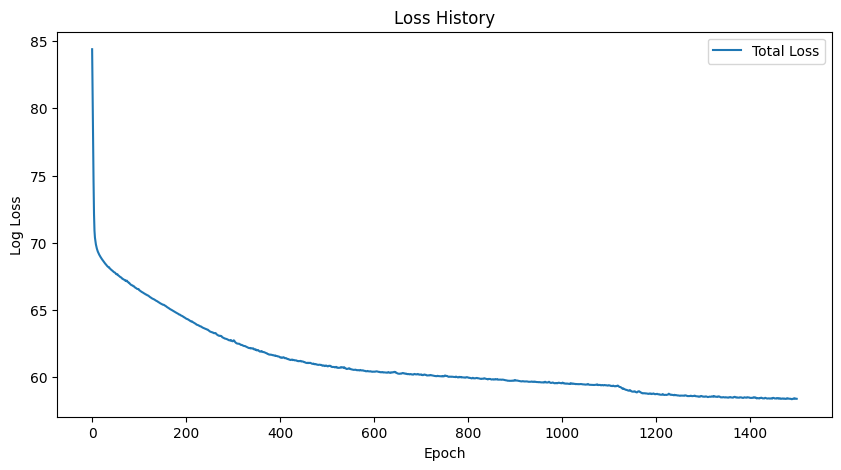

Model:  best_model.pth


Model:  checkpoint.pth


In [28]:
audio_path = "../sounds/all sounds/shards.wav"
loudness_normalization = "specific"
random_shift = True
summary      = True

#play original sound
display(Audio(audio_path))
sound_test("model_227", audio_path, loudness_normalization, random_shift, summary)
# sound_test("model_206", audio_path, loudness_normalization, random_shift, summary)
# sound_test("model_207", audio_path, loudness_normalization, random_shift, summary)

In [10]:
# import matplotlib.pyplot as plt

# # testing controllability
# def rate_tester(model_id, audio_path, loudness_normalization, random_shift, summary=False):
#     # Loading all models in the folder
#     model_folder = os.path.join("../trained_models/", model_id)

#     # model folder building
#     if not os.path.exists(model_folder):
#         model_folder = model_folder+"_complete"

#     # get all models in the folder
#     model_dict = models_in_folder(model_folder, summary)

#     configurations_path = model_dict["path_configuration"]
#     loss_dict_path      = model_dict["path_loss"]
#     models              = model_dict["path_models"]

#     models_list = []
#     for model_address in models:
#         model_name, model_path = model_address
#         model, seed, checkpoint = model_tester.model_loader(model_path, configurations_path)
#         print("Model loaded: ", model_name)
#         models_list.append([model_name, model, seed])

#     parameters_dict = model_json_to_parameters(configurations_path)
#     with open(loss_dict_path, 'rb') as file:
#         loss_dict = pickle.load(file)

#     # plot loss history
#     model_tester.plot_loss_history(loss_dict)

#     for model_pack in models_list:
#         name, model, seed = model_pack
#         # preprocess the audio data using the corresponding parameters
#         frame_size          = parameters_dict["frame_size"]
#         features_annotators = parameters_dict["features"]
#         index = next(i for i, f in enumerate(features_annotators) if f.__name__ == "features_rate")
#         index = index + 1
#         sampling_rate       = parameters_dict["sampling_rate"]
#         N_filter_bank       = parameters_dict["N_filter_bank"] 
#         erb_bank            = EqualRectangularBandwidth(frame_size, sampling_rate, N_filter_bank, 20, sampling_rate // 2)
#         content             = model_tester.audio_preprocess(audio_path, frame_size, sampling_rate, features_annotators, erb_bank)
#         content_2 = content.copy()
#         rate_list = []
#         rate_manipulated_list = []
#         for i in range(len(content_2)):
#             rate = content[i][index].cpu().numpy()
#             rate_list.append(rate)
#             # manipulation
#             rate_manipulated = torch.zeros_like(content[i][index])
#             rate_manipulated_list.append(1)
#             content_2[i][index] = torch.tensor(rate_manipulated, device="cuda")
#         plt.plot(rate_list)
#         plt.show()
#         resynthesis = model_tester.model_synthesizer(content,   model, parameters_dict, loudness_normalization, seed, random_shift)
#         print("rate normal")
#         display(Audio(resynthesis, rate=sampling_rate))
#         plt.plot(rate_manipulated_list)
#         plt.show()
#         print("rate manipulated")
#         resynthesis = model_tester.model_synthesizer(content_2, model, parameters_dict, loudness_normalization, seed, random_shift)
#         display(Audio(resynthesis, rate=sampling_rate))
    
# audio_path = "../sounds/all sounds/fire.wav"
# loudness_normalization = "specific"
# random_shift = True
# summary      = True

# # rate_tester("model_186", audio_path, loudness_normalization, random_shift, summary)
# rate_tester("model_187", audio_path, loudness_normalization, random_shift, summary)